In [7]:
import pandas as pd
import numpy as np

# 1. Load the dataset (Ensure you use the enriched version from the previous notebook)
df = pd.read_csv('../data/processed/final_feature_set.csv')

# 2. Identify and drop non-predictive/target columns
# We drop 'churn' (target) and any ID columns
cols_to_exclude = ['churn', 'customer_id']
existing_excludes = [c for c in cols_to_exclude if c in df.columns]

# 3. Automatic Categorical Encoding
# This identifies any 'object' or 'category' columns and converts them to 0s and 1s.
# 'drop_first=True' is crucial to avoid the Dummy Variable Trap.
df_encoded = pd.get_dummies(df, drop_first=True)

# 4. Define X (Features) and y (Target)
X = df_encoded.drop(columns=existing_excludes)
y = df_encoded['churn']

print(f"Encoding Complete.")
print(f"Original Columns: {len(df.columns)} | Encoded Columns: {len(df_encoded.columns)}")
print(f"Sample of encoded features: {list(X.columns[:5])}")

Encoding Complete.
Original Columns: 18 | Encoded Columns: 19
Sample of encoded features: ['credit_score', 'gender', 'age', 'tenure', 'balance']


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Stratified Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize and apply Scaler
scaler = StandardScaler()

# Fit on training data ONLY (to prevent data leakage) and transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("SUCCESS: Scaling complete. Data is now ready for modeling.")
print(f"Training shape: {X_train_scaled.shape}")

SUCCESS: Scaling complete. Data is now ready for modeling.
Training shape: (7920, 18)


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def tune_random_forest(X_train, y_train):
    """
    Performs Grid Search Cross-Validation to find the optimal 
    hyperparameters for the Random Forest model.
    """
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', 'balanced_subsample']
    }

    # Initialize the base model
    rf = RandomForestClassifier(random_state=42)

    # Initialize Grid Search with 5-fold cross-validation
    # We use 'roc_auc' as the scoring metric because the classes are imbalanced
    grid_search = GridSearchCV(
        estimator=rf, 
        param_grid=param_grid, 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validation AUC: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Execute tuning
# Note: We use the unscaled X_train for Random Forest as tree models don't require scaling,
# but using the scaled version is also fine.
best_rf_model = tune_random_forest(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation AUC: 0.8638


--- Detailed Classification Report ---
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      1578
         1.0       0.59      0.63      0.61       402

    accuracy                           0.84      1980
   macro avg       0.75      0.76      0.75      1980
weighted avg       0.84      0.84      0.84      1980



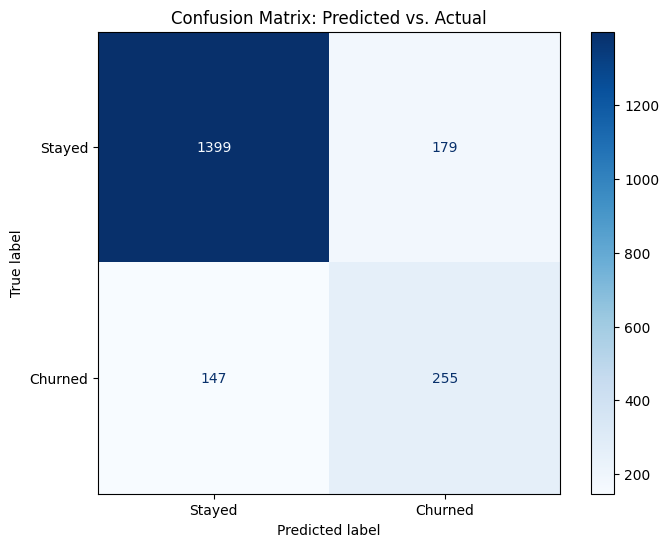

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def evaluate_model_performance(model, X_test, y_test):
    """
    Generates a classification report and a visual confusion matrix.
    """
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Print Classification Report
    print("--- Detailed Classification Report ---")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Churned'])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax)
    plt.title('Confusion Matrix: Predicted vs. Actual')
    plt.grid(False) # Clean up the visual
    plt.show()

# Evaluate the best model from the grid search
evaluate_model_performance(best_rf_model, X_test, y_test)

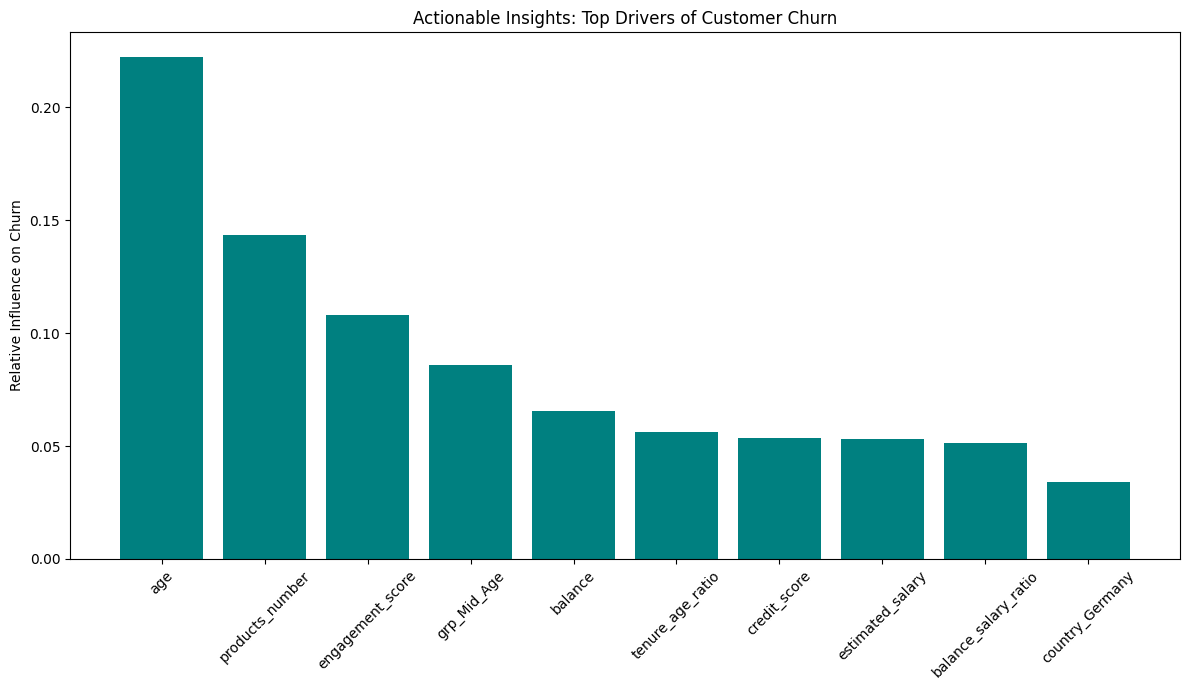

In [18]:
def plot_business_drivers(model, feature_names):
    """
    Visualizes the top features driving the model's predictions.
    """
    # Extract importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Create the plot
    plt.figure(figsize=(12, 7))
    plt.title("Actionable Insights: Top Drivers of Customer Churn")
    plt.bar(range(len(importances[:10])), importances[indices[:10]], color='teal', align="center")
    plt.xticks(range(len(importances[:10])), [feature_names[i] for i in indices[:10]], rotation=45)
    plt.ylabel('Relative Influence on Churn')
    plt.tight_layout()
    plt.show()

# Identify drivers using the column names from our encoded X
plot_business_drivers(best_rf_model, X.columns)

In [20]:
import joblib

# Save model and scaler
joblib.dump(gb_model, '../models/churn_model_gb.pkl')
joblib.dump(scaler, '../models/standard_scaler.pkl')

print("SUCCESS: Model artifacts saved to ../models/")

SUCCESS: Model artifacts saved to ../models/
